# Hyperparamenter-tunning with Keras Tuner

## 0. Imports

In [ ]:
#!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

<ipython-input-3-fe85bac8af47>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## 1. Dataset

We will use the Fashion MNIST dataset, which is a drop-in replacement of MNIST (already introduced). It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse and the problem is more challenging.

In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


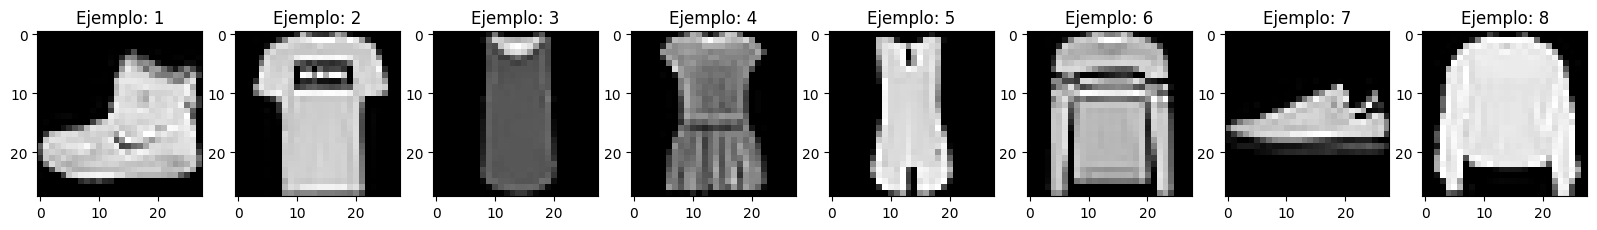

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))

for index, e in enumerate(img_train[:8]):
    plt.subplot(1, 8, index+1)
    plt.imshow(e, cmap=plt.cm.gray)
    plt.title('Ejemplo: ' + str(index+1))

plt.show()

In [ ]:
# Normalize the pixel values between 0 and 1 (dividimos entre el valor maximo)
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

## 2. Model definition

When building a model to perform _hypertuning_, the hyperparameter search space must be defined in addition to the model architecture. The model you set to perform _hypertuning_ is called _hypermodel_.

You can define a _hypermodel_ through two approaches:

* Implementing a function that builds the model (like in this jupyter notebook), which is easier and more intuitive.
* Creating a subclass of the `HyperModel` class of the Keras Tuner API

You can also use two predefined `HyperModel` classes, `HyperXception` and `HyperResNet` for computer vision applications.

In this tutorial, we implement a function that builds an image classification model. The function returns a compiled model and uses the defined hyperparameters to perform _hypertuning_ on it.

In [ ]:
def model_builder(hp):

    # Model definition
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) # Flatten transforms the matrix 28x28 into an array.

    # Tunning number of layers in the first hidden layer
    # Select optimum value between 32 y 512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32) # Int recorre el rango
    model.add(keras.layers.Dense(units = hp_units, activation='relu'))

    # Tunning learning rate for the optimization algorithm
    # Select the optimum value between  [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # choice escoge entre las opciones

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model


The `hp` parameter that the function receives corresponds to an object of the `HyperParameters` class, which, in general, corresponds to a "store" of hyperparameters.

## 3.  _hypertuning_ performance


Once the previous function is defined, the Tuner is instantiated to perform _hypertuning_. The _Keras Tuner_ has four _tuners_ available - `RandomSearch`, `Hyperband`, `BayesianOptimization` and `Sklearn`. In this tutorial, `Hyperband` is used : (https://arxiv.org/pdf/1603.06560.pdf). You can check the documention for mor einformation on the others.

To instantiate the Hyperband _tuner_, you must specify the _hypermodel_, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'test_dir',
    project_name = 'hp_tuning'
)

In [ ]:
# tuner execution to search for the hyperparameters
tuner.search(
    img_train,
    label_train,
    epochs = 10,
    validation_data = (img_test, label_test) # here it should technically be the validation set, for teaching purposes only we will use the test
)

Trial 30 Complete [00h 01m 06s]
val_accuracy: 0.6431000232696533

Best val_accuracy So Far: 0.847100019454956
Total elapsed time: 00h 25m 17s


In [ ]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Learning rate:", best_hps.get('learning_rate'))

Units: 160
Learning rate: 0.001


## 5. Model training

In [ ]:
model = tuner.hypermodel.build(best_hps) # we use the tuner to get the model with the best hyperparameters

history = model.fit(
    img_train,
    label_train,
    epochs = 10,
    validation_data = (img_test, label_test)
)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.7329 - accuracy: 0.6700 - val_loss: 1.5311 - val_accuracy: 0.7030
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.4705 - accuracy: 0.7147 - val_loss: 1.4786 - val_accuracy: 0.7114
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.4312 - accuracy: 0.7210 - val_loss: 1.4517 - val_accuracy: 0.7158
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.4102 - accuracy: 0.7237 - val_loss: 1.4362 - val_accuracy: 0.7172
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.3969 - accuracy: 0.7254 - val_loss: 1.4331 - val_accuracy: 0.7151
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.3867 - accuracy: 0.7277 - val_loss: 1.4267 - val_accuracy: 0.7181
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.3802 - accuracy: 0.7277 - val_loss: 1.4213 - val_accuracy:

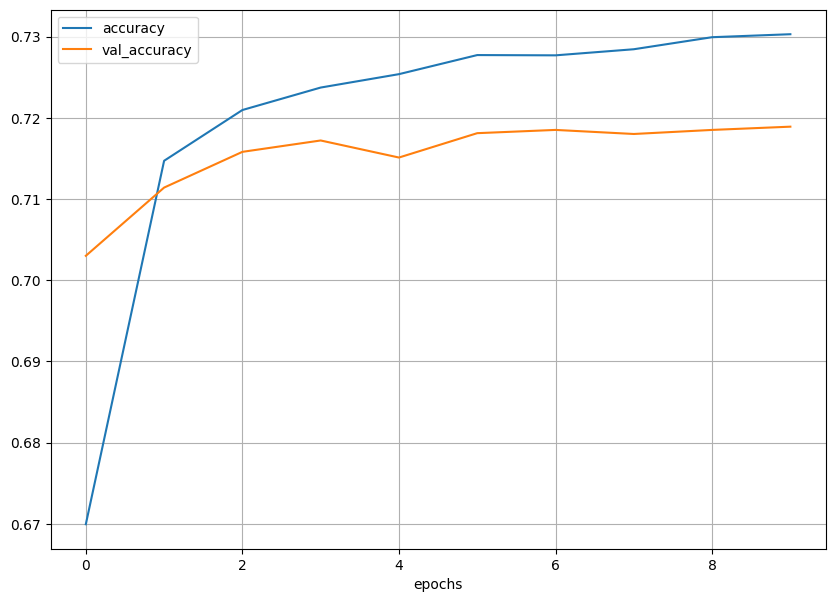

In [ ]:
import pandas as pd

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel("epochs")
plt.show()